# ARDL models

An autoregressive distributed lag (ARDL) model is one that contains both lagged xt’s and
lagged yt’s. In its general form, with p lags of y and q lags of x, an ARDL(p, q) model can be
written as:





\begin{equation*}
y_t=δ + θ_1 y_{(t-1)}+ ... + θ_p y_{(t-p)}+δ_0 x_t+δ_1 x_{(t-1)}+ ... +δ_q x_{(t-q)}+v_t
\end{equation*}

There are a number of different criteria for choosing p and q. Because they all do not
necessarily lead to the same choice, there is a degree of subjective judgment that must be
used. Four possible criteria are
1. Has serial correlation in the errors been eliminated? If not, then least squares will be
biased in small and large samples. It is important to include sufficient lags, especially
of y, to ensure that serial correlation does not remain. It can be checked using the
correlogram or Lagrange multiplier tests.
2. Are the signs and magnitudes of the estimates consistent with our expectations from
economic theory? Estimates which are poor in this sense may be a consequence of
poor choices for p and q, but they could also be symptomatic of a more general
modeling problem.
3. Are the estimates significantly different from zero, particularly those at the longest
lags?
4. What values for p and q minimize information criteria such as the AIC and SC?
Information criteria were first considered in Chapter 6. In the context of the ARDL
model they involve choosing p and q to minimize the sum of squared errors (SSE)
subject to a penalty that increases as the number of parameters increases. Increasing
lag lengths increases the number of parameters, and, providing we use the same
number of observations in each case,11 it reduces the sum of squared errors; penalty
terms are included with a view to capturing the essential lag effects without
introducing an excessive number of parameters. The Akaike information criterion
(AIC) is given by

\begin{equation*}
AIC = ln (\frac{SSE}{T}) + \frac{2K}{T}
\end{equation*}

In [79]:
#Import the main libraries. 
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas.core import datetools
from pandas import Series, DataFrame

In [80]:
#load the .dta (stata) format data on US GDP from quarter 2, 1985 to quarter 3, 2009 (g GDP, u Unempl)
df = pd.read_stata('okun.dta')

In [81]:
df.head()

,g,u
0,1.4,7.3
1,2.0,7.2
2,1.4,7.0
3,1.5,7.0
4,0.9,7.2


In [82]:
#Create data index
ts = pd.period_range('1985Q2', periods=98, freq='Q')
df['Date'] = ts
df.set_index('Date')

,g,u
Date,,
1985Q2,1.4,7.3
1985Q3,2.0,7.2
1985Q4,1.4,7.0
1986Q1,1.5,7.0
1986Q2,0.9,7.2
1986Q3,1.5,7.0
1986Q4,1.2,6.8
1987Q1,1.5,6.6
1987Q2,1.6,6.3


In [83]:
#Create laged and differenced variables for further analysis
df['lag_g1'] = df['g'].shift(1)
df['lag_g2'] = df['g'].shift(2)
df['du'] = df['u'].diff(periods=1)
df['lag_du'] = df['du'].shift(1)

In [84]:
df.head()

,g,u,Date,lag_g1,lag_g2,du,lag_du
0,1.4,7.3,1985Q2,NaN,NaN,NaN,NaN
1,2.0,7.2,1985Q3,1.4,NaN,-0.1,NaN
2,1.4,7.0,1985Q4,2.0,1.4,-0.2,-0.1
3,1.5,7.0,1986Q1,1.4,2.0,0.0,-0.2
4,0.9,7.2,1986Q2,1.5,1.4,0.2,0.0


Before proceeding to analysis, let's understand the purpose. We want to estimate empirically the Okun's law for US for the period under consideration. Okun's Law represents the relationship between the change in Unemployment and the rate of growth of output in the economy

\begin{equation*}
U_t - U_{t-1} = - \gamma (G_t - G_N)
\end{equation*}

In [85]:
# Import the linear regression from statsmodels
import statsmodels.api as sm

In [86]:
# drop columns and nan values
df.dropna(inplace=True)

In [87]:
# Prepare target and input variables. 
X_multi=df.drop(['u','Date','du','lag_du'], axis=1)
Y_target=df.du

In [88]:
# Add the costant to our input variables
X_multi=sm.tools.tools.add_constant(X_multi, prepend=True, has_constant='skip')

In [89]:
# OLS Regression
mod = sm.OLS(Y_target, X_multi)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     du   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     57.95
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           3.96e-21
Time:                        10:04:44   Log-Likelihood:                 34.476
No. Observations:                  96   AIC:                            -60.95
Df Residuals:                      92   BIC:                            -50.69
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5836      0.047     12.360      0.0

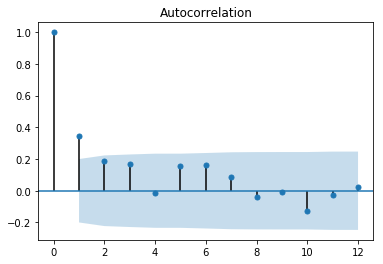

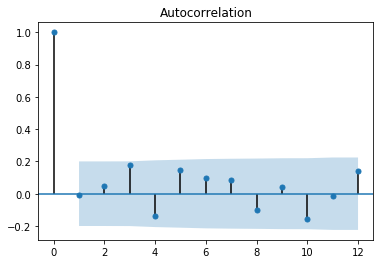

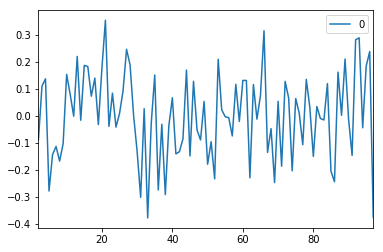

In [93]:
# Check the autocorrelation of errors after fitting the model as above. 
model_fit = mod.fit(disp=0)
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

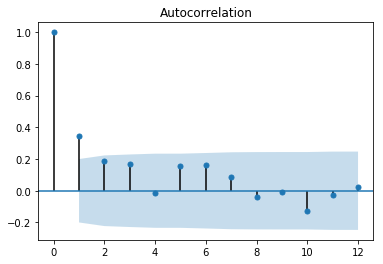

In [91]:
# you can also use this command to get the autocorrelation of errors. 
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals,lags=12)

                            OLS Regression Results                            
Dep. Variable:                     du   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     51.66
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           1.25e-22
Time:                        10:04:45   Log-Likelihood:                 40.423
No. Observations:                  96   AIC:                            -70.85
Df Residuals:                      91   BIC:                            -58.02
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3876      0.072      5.382      0.0

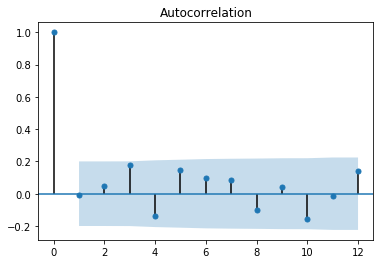

In [92]:
# There is autocorrelation in errors, so we try ARDL (1,2)
X1_multi=df.drop(['u','Date','du'], axis=1)
Y_target=df.du
X1_multi=sm.tools.tools.add_constant(X1_multi, prepend=True, has_constant='skip')
mod = sm.OLS(Y_target, X1_multi)
res = mod.fit()
print(res.summary())
model_fit = mod.fit(disp=0)
residuals = DataFrame(model_fit.resid)
plot_acf(residuals,lags=12)

Are you satisfied with the model that you obtain? What would you change to get a better model? What criteria do you use to make that statement?

Once you have answered the previous question and estimated the final model, how would you apply that to forecast the unemployment in the 4th Quarter of 2009 and 1st Quarter of 2010? Can you try to do this?